# Motion Classification
Created 2021.02.21 by Kevin Ta

In [1]:
# Import relevant modules
import os
import glob
import time
from datetime import datetime
from scipy import signal

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
COUNT_ZERO = False

TERRAINS = ['Asphalt', 'Carpet', 'Concrete', 'Gravel', 'Grass', 'Linoleum', 'Sidewalk']
TERRAINS_R1 = ['No Motion','Indoor', 'Asphalt-Sidewalk', 'Grass', 'Gravel']
TERRAINS_R2 = ['No Motion','Indoor', 'Outdoor']

#TEST_SET = [('Keenan', 'Gravel', 'F8')]
TEST_SET = [('Mahsa', 'Grass', 'F8')]

PERSON = 'Everyone'

SOURCE = '0512-Time-Relabelled2-New'

nonzero = 0

current_path = os.getcwd()

y_true = np.array([])
y_pred = np.array([])
timeDiffs = np.array([0])

for dataset in TEST_SET:

    data = pd.read_csv(os.path.join('2021-Results', SOURCE, '200ms-6050-{}-{}-{}.csv'.format(dataset[1], dataset[2], dataset[0])))
    
    y_pred_temp = data['RF Time'].to_numpy(dtype=np.int8)
    y_true_temp = data['True Label'].to_numpy(dtype=np.int8)
    timeDiffs_temp = np.diff(data['Time'].to_numpy())
    nonzero += len(y_true_temp) - len(y_pred_temp)
    
    y_true = np.append(y_true, y_true_temp[0:len(y_pred_temp)])
    y_pred = np.append(y_pred, y_pred_temp)
    timeDiffs = np.append(timeDiffs, timeDiffs_temp[0:len(y_pred_temp)])
    
    print(y_true.shape)
    print(y_pred.shape)
    print(timeDiffs.shape)

if COUNT_ZERO:
    y_true = np.append(y_true, np.zeros(nonzero))
    y_pred = np.append(y_pred, np.zeros(nonzero))

(9717,)
(9717,)
(9717,)


(9717,)


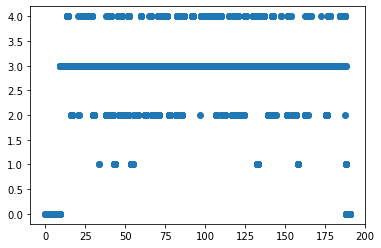

In [3]:
times = np.cumsum(timeDiffs)
print(times.shape)

#f_ind = (y_pred!=0).argmax(axis=0)

#y_pred = np.trim_zeros(y_pred)
#y_true = y_true[f_ind:f_ind+len(y_pred)]
#times = times[f_ind:f_ind+len(y_pred)]

plt.scatter(times, y_pred)

In [4]:
motionData = pd.read_csv(os.path.join('set_power', 'Middle_{}Power{}{}_Module6050.csv'.format(dataset[1], dataset[2], dataset[0])))

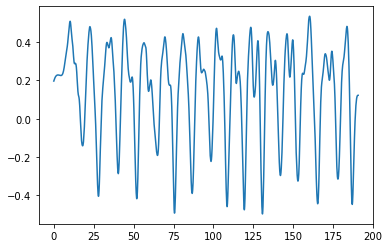

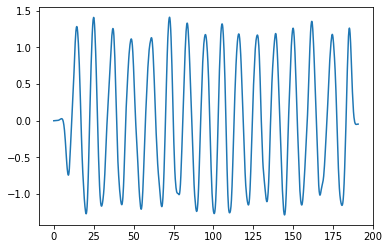

In [5]:
# Get normalized frequencies
w_low = 2 * 0.2 / 300

# Get Butterworth filter parameters
sos = signal.butter(N=2, Wn=w_low, btype='low', output='sos')

xAccel = motionData['ACCELEROMETER X (m/s²)']
zGyro = motionData['GYROSCOPE Z (rad/s)']

xAccel_filt = signal.sosfiltfilt(sos, xAccel)
zGyro_filt = signal.sosfiltfilt(sos, zGyro)

plt.figure()
plt.plot(motionData['Time since start in ms '], xAccel_filt)

plt.figure()
plt.plot(motionData['Time since start in ms '], zGyro_filt)

Text(0.5, 1.0, 'Classification Accuracy & Gyroscope Motion')

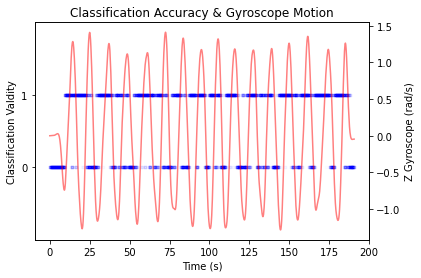

In [6]:
fig,ax1 = plt.subplots()
ax2 =ax1.twinx()
ax1.scatter(times, y_pred==y_true, c='b', marker='.', alpha=0.01)
ax2.plot(motionData['Time since start in ms '], zGyro_filt, 'r', alpha = 0.5)
ax1.set_xlabel('Time (s)')
ax1.set_yticks([0,1])
ax1.set_ylim([-1,2])
ax2.set_ylabel('Z Gyroscope (rad/s)')
ax1.set_ylabel('Classification Valdity')
ax1.set_title('Classification Accuracy & Gyroscope Motion')

9598
474


Text(0.5, 1.0, 'Classification vs. Gyroscopic Motion')

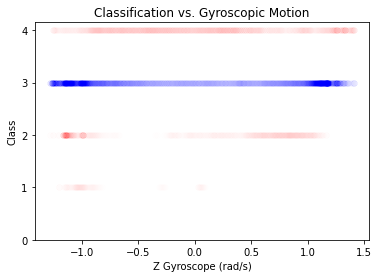

In [7]:
zGyro_interp = np.interp(times, motionData['Time since start in ms '], zGyro_filt)

correct_ind = y_pred==y_true
incorrect_ind = y_pred!=y_true

in_ind = y_pred==1
sa_ind = y_pred==2
gs_ind = y_pred==3
gv_ind = y_pred==4

f_ind = (y_pred!=0).argmax(axis=0)
l_ind = len(y_pred) - (np.flip(y_pred)!=0).argmax(axis=0)

print(l_ind)
print(f_ind)
incorrect_ind[0:f_ind] = False
incorrect_ind[l_ind:] = False

plt.figure()
plt.scatter(zGyro_interp[correct_ind], y_pred[correct_ind], c='b', marker='o', alpha=0.005)
plt.scatter(zGyro_interp[incorrect_ind], y_pred[incorrect_ind], c='r', marker='o', alpha=0.005)
plt.xlabel('Z Gyroscope (rad/s)')
plt.ylabel('Class')
plt.yticks([0,1,2,3,4])
plt.title('Classification vs. Gyroscopic Motion')

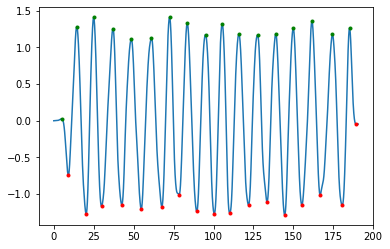

In [8]:
minGyro = signal.argrelmin(zGyro_interp, order = 10)
maxGyro = signal.argrelmax(zGyro_interp, order = 10)
            
plt.plot(times, zGyro_interp)
plt.plot(times[minGyro], zGyro_interp[minGyro], 'r.')
plt.plot(times[maxGyro], zGyro_interp[maxGyro], 'g.')

4.8827173709869385
14.381909370422363


Text(0.5, 1.0, 'Location Errors for Grass F8 Mahsa')

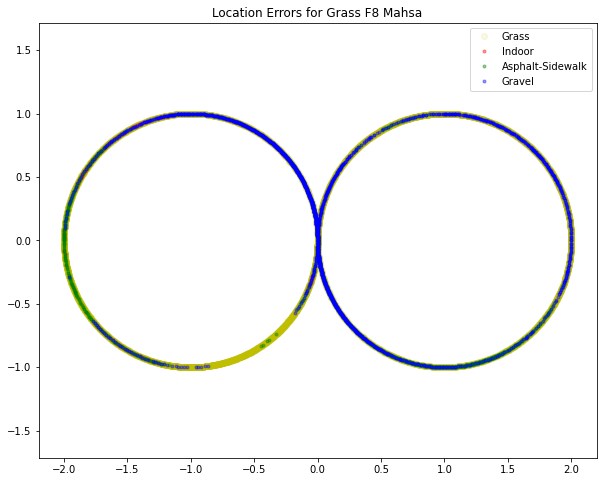

In [13]:
x = np.zeros(len(zGyro_interp))
y = np.zeros(len(zGyro_interp))

t = 0

for i in range(len(maxGyro[0])+len(minGyro[0])):
    if i == 0:
        while times[t] < times[maxGyro[0][0]]:
            x[t] = 0
            y[t] = 0
            t = t + 1
    elif i == 1:
        diffTime = (times[minGyro[0][0]] - times[maxGyro[0][0]])
        while times[t] < times[minGyro[0][0]]:
            x[t] = -1 - 1 * np.sin( 2 * np.pi * (times[t] - times[maxGyro[0][0]]) / (diffTime) )
            y[t] =    + 1 * np.cos( 2 * np.pi * (times[t] - times[maxGyro[0][0]]) / (diffTime) )
            t = t + 1
    elif i%2 == 0:
        ind = int(i/2)
        diffTime = (times[maxGyro[0][ind]] - times[minGyro[0][ind - 1]])
        halfTime = times[minGyro[0][ind- 1]] + diffTime / 2
        fullTime = times[minGyro[0][ind- 1]] + diffTime
        while times[t] < halfTime:
            x[t] = -1 - 1 * np.cos( 2 * np.pi * (times[t] - times[minGyro[0][ind - 1]]) / diffTime )
            y[t] =    - 1 * np.sin( 2 * np.pi * (times[t] - times[minGyro[0][ind - 1]]) / diffTime )
            t = t + 1
        while times[t] < fullTime:
            x[t] =  1 + 1 * np.cos( 2 * np.pi * (times[t] - times[minGyro[0][ind - 1]]) / diffTime )
            y[t] =    - 1 * np.sin( 2 * np.pi * (times[t] - times[minGyro[0][ind - 1]]) / diffTime )
            t = t + 1
    elif i%2 == 1:
        ind = int(i/2)
        diffTime = (times[minGyro[0][ind]] - times[maxGyro[0][ind]])
        halfTime = times[maxGyro[0][ind]] + diffTime / 2
        fullTime = times[maxGyro[0][ind]] + diffTime
        while times[t] < halfTime:
            x[t] =  1 + 1 * np.cos( 2 * np.pi * (times[t] - times[maxGyro[0][ind]]) / diffTime )
            y[t] =    - 1 * np.sin( 2 * np.pi * (times[t] - times[maxGyro[0][ind]]) / diffTime )
            t = t + 1
        while times[t] < fullTime:
            x[t] = -1 - 1 * np.cos( 2 * np.pi * (times[t] - times[maxGyro[0][ind]]) / diffTime )
            y[t] =    - 1 * np.sin( 2 * np.pi * (times[t] - times[maxGyro[0][ind]]) / diffTime )
            t = t + 1
    #print(times[t])

print(times[maxGyro[0][0]])
print(times[maxGyro[0][1]])

plt.figure(figsize=(10,8))
#plt.plot(x,y, 'r-', alpha = 0.5)
#plt.plot(x[correct_ind],y[correct_ind], 'b.', alpha = 0.2)
#plt.plot(x[incorrect_ind],y[incorrect_ind], 'r.', alpha = 0.2)
#plt.legend(['Correct','Incorrect'])
plt.plot(x[gs_ind],y[gs_ind], 'yo', alpha = 0.1)
plt.plot(x[in_ind],y[in_ind], 'r.', alpha = 0.4)
plt.plot(x[sa_ind],y[sa_ind], 'g.', alpha = 0.4)
plt.plot(x[gv_ind],y[gv_ind], 'b.', alpha = 0.4)
plt.legend(["Grass", "Indoor", "Asphalt-Sidewalk", "Gravel"])
plt.axis('equal')
plt.title('Location Errors for {} {} {}'.format(dataset[1], dataset[2], dataset[0]))